# DrivenData: Heart disease prediction using Logistic Regression and SVM

###### BY ANNE DE GRAAF

This notebook is meant to show my train of thoughts during the development of prediction model for the heart disease warm-up exercise on DrivenData.org. 

[key words: ...]

In [43]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2_contingency
from functions import logLoss
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

## Loading data

In [2]:
# load (normalized) training data
X = pd.read_csv('../train_values_normalized.csv', index_col=0)
y = pd.read_csv('../train_labels.csv', index_col=0)

# load (normalized) test data
X_test = pd.read_csv('../test_values_normalized.csv', index_col=0)

In [3]:
# adding polynomial features to the set

# only polynomials of the numerical features are included:
numeric_cols = ['resting_blood_pressure', 'num_major_vessels', 'fasting_blood_sugar_gt_120_mg_per_dl', 
                     'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age', 'max_heart_rate_achieved']

# the rest of the columns are categorical data:
categoric_data = X.copy()
categoric_data.drop(numeric_cols, axis=1, inplace=True)

# make 2nd degree poly features from numerical data
polynomials = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
poly_features = polynomials.fit_transform(X[numeric_cols])

# normalize data to mean=0 and std=1
scaler = StandardScaler(copy=False, with_mean=True, with_std=True).fit(poly_features)
poly_features = scaler.transform(poly_features)

# make data frame with all data
poly_train_df = pd.DataFrame(data=poly_features,
                             index=X.index,
                             columns=polynomials.get_feature_names(numeric_cols))
poly_train_df = poly_train_df.join(categoric_data)

In [4]:
# make poly df for test set
categoric_test = X_test.copy()
categoric_test.drop(numeric_cols, axis=1, inplace=True)
poly_test = polynomials.fit_transform(X_test[numeric_cols])
poly_test = scaler.transform(poly_test)
poly_test_df = pd.DataFrame(data=poly_test,
                           index=X_test.index,
                           columns=polynomials.get_feature_names(numeric_cols))
poly_test_df = poly_test_df.join(categoric_test)

In [5]:
# load original data
X_raw = pd.read_csv('../train_values.csv', index_col=0)
y_raw = pd.read_csv('../train_labels.csv', index_col=0)

# split data in train and crossval 70:30
X_train, X_test, y_train, y_test = train_test_split(X_raw, 
                y_raw, test_size=0.3, random_state=7)

## Feature selection: categorical features (using Pearson's chi-squared test)

In [6]:
# 1. sex vs heart disease

ct_table1 = pd.crosstab(y_train['heart_disease_present'], X_train['sex'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table1, correction=False)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table1

P is 0.000588
H0 rejected, no indepence. Use feature in model.
  
Contingency table:


sex,0,1
heart_disease_present,,
0,33,39
1,9,45


In [7]:
# 2. exercise induced angina vs heart disease
ct_table2 = pd.crosstab(y_train['heart_disease_present'], X_train['exercise_induced_angina'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table2, correction=False)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table2

P is 0.000000
H0 rejected, no indepence. Use feature in model.
  
Contingency table:


exercise_induced_angina,0,1
heart_disease_present,,
0,63,9
1,21,33


In [8]:
# 3. slope of peak exercise st segment vs heart disease
ct_table3 = pd.crosstab(y_train['heart_disease_present'], X_train['slope_of_peak_exercise_st_segment'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table3, correction=False)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table3

P is 0.000304
H0 rejected, no indepence. Use feature in model.
  
Contingency table:


slope_of_peak_exercise_st_segment,1,2,3
heart_disease_present,,,
0,46,22,4
1,15,34,5


In [9]:
# 4. thal vs heart disease
ct_table4 = pd.crosstab(y_train['heart_disease_present'], X_train['thal'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table4, correction=True)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table4

P is 0.000000
H0 rejected, no indepence. Use feature in model.
  
Contingency table:


thal,fixed_defect,normal,reversible_defect
heart_disease_present,,,
0,3,55,14
1,2,13,39


In [10]:
# 5. chest pain type vs heart disease
ct_table5 = pd.crosstab(y_train['heart_disease_present'], X_train['chest_pain_type'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table5, correction=True)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table5

P is 0.000000
H0 rejected, no indepence. Use feature in model.
  
Contingency table:


chest_pain_type,1,2,3,4
heart_disease_present,,,,
0,6,18,32,16
1,2,2,8,42


In [11]:
# 6. resting EKG results vs heart disease
ct_table6 = pd.crosstab(y_train['heart_disease_present'], X_train['resting_ekg_results'], margins=False)
chi2, p, dof, ex = chi2_contingency(ct_table6, correction=True)
# print(chi2, p, dof, ex)

print( 'P is %f' %p )
if p <= 0.05:
    print('H0 rejected, no indepence. Use feature in model.')
else:
    print('H0 not rejected, indepence. Do not use feature in model.')

print('  ')
print('Contingency table:')
ct_table6

P is 0.298733
H0 not rejected, indepence. Do not use feature in model.
  
Contingency table:


resting_ekg_results,0,1,2
heart_disease_present,,,
0,38,0,34
1,23,1,30


In [12]:
# deleting Resting EKG results from datasets
EKG_cols = ['restingEkg_0', 'restingEkg_1', 'restingEkg_2']
poly_train_df.drop(EKG_cols, axis=1, inplace=True)
poly_test_df.drop(EKG_cols, axis=1, inplace=True)

## Feature selection: numerical features (using the Lasso)

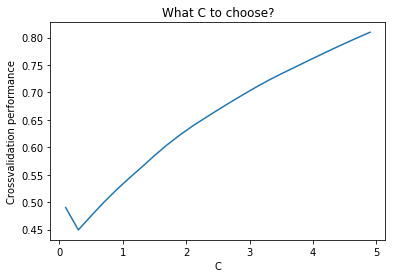

In [34]:
X = poly_train_df
C_list = np.arange(.1, 5.0, .2)
crossVal_loss = np.zeros(len(C_list))

for j in range(len(C_list)):
    str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    crossVal_performance = np.zeros(str_kFold.get_n_splits())
    logRes_params = LogisticRegression(penalty='l1', C=C_list[j], 
                    fit_intercept=False, tol=1e-8, solver='liblinear', max_iter=300)
    i=int(0)
    for iTrain, iCross in str_kFold.split(X, y):
        X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
        y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
        model_i = logRes_params.fit(X_train, np.ravel(y_train))
        prob_i = model_i.predict_proba(X_cross)
        crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
        i+=1
    crossVal_loss[j] = np.mean(crossVal_performance)

plt.plot(C_list, crossVal_loss)
plt.xlabel('C')
plt.ylabel('Crossvalidation performance')
plt.title('What C to choose?');

C=0.25 seems optimal


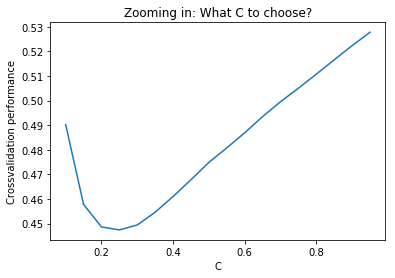

In [38]:
# "zooming in" on minimum. Change C_list
C_list = np.arange(.1, 1.0, .05)
crossVal_loss = np.zeros(len(C_list))

for j in range(len(C_list)):
    str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    crossVal_performance = np.zeros(str_kFold.get_n_splits())
    logRes_params = LogisticRegression(penalty='l1', C=C_list[j], 
                    fit_intercept=False, tol=1e-8, solver='liblinear', max_iter=300)
    i=int(0)
    for iTrain, iCross in str_kFold.split(X, y):
        X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
        y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
        model_i = logRes_params.fit(X_train, np.ravel(y_train))
        prob_i = model_i.predict_proba(X_cross)
        crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
        i+=1
    crossVal_loss[j] = np.mean(crossVal_performance)

plt.plot(C_list, crossVal_loss)
plt.xlabel('C')
plt.ylabel('Crossvalidation performance')
plt.title('Zooming in: What C to choose?');

print('C=0.25 seems optimal')

In [42]:
# the model with C=0.25:
logRes_params = LogisticRegression(penalty='l1', C=0.25, 
        fit_intercept=False, tol=1e-8, solver='liblinear', max_iter=300)

# performance on crossval set:
str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
crossVal_performance = np.zeros(str_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in str_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = logRes_params.fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1
print('crossval performance: %0.5f' %np.mean(crossVal_performance))

# performance on entire train set:
logRes_fit = logRes_params.fit(X, np.ravel(y))
train_prob = logRes_fit.predict_proba(X)
print('train performance: %0.5f' %logLoss(y, train_prob)[0,1])

crossval performance: 0.44742
train performance: 0.37651


In [41]:
# performance on test set:
test_probab = logRes_fit.predict_proba(poly_test_df)[:,1]

# saving test results
d = {'heart_disease_present': test_probab}
submission_df = pd.DataFrame(data=d, index=poly_test_df.index)
submission_df.to_csv('../logResModel_Lasso1_results.csv')

print('gives a test performance of 0.37544')

gives a test performance of 0.37544


Let's try if an elastic net can improve results. 

In [54]:
alpha_list = np.arange(0.1, 5.1, 0.5)
ratio_list = np.arange(0.0, 1.0, 0.1)
crossVal_loss = np.zeros((len(alpha_list), len(ratio_list)))

for j in range(len(alpha_list)):
    for k in range(len(ratio_list)): 
        elasticNet_params =  SGDClassifier(loss='log', penalty='elasticnet', 
            alpha=alpha_list[j], l1_ratio=ratio_list[k], fit_intercept=False, 
            max_iter=300)
        str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        crossVal_performance = np.zeros(str_kFold.get_n_splits())
        i=int(0)
        for iTrain, iCross in str_kFold.split(X, y):
            X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
            y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
            model_i = elasticNet_params.fit(X_train, np.ravel(y_train))
            prob_i = model_i.predict_proba(X_cross)
            crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
            i+=1
        crossVal_loss[j,k] = np.mean(crossVal_performance)

In [55]:
best_fit = crossVal_loss.min()
index_j, index_k = np.unravel_index(np.argmin(crossVal_loss), crossVal_loss.shape)
print('best performance is: %0.5f' %best_fit)
print('best alpha is: %f' %alpha_list[index_j])
print('best ratio is: %f' %ratio_list[index_k])

best performance is: 0.47281
best alpha is: 0.100000
best ratio is: 0.000000


In [56]:
# Doing it again with smaller alphas..
alpha_list = np.arange(0.01, 0.2, 0.01)
ratio_list = np.arange(0.0, 1.0, 0.1)
crossVal_loss = np.zeros((len(alpha_list), len(ratio_list)))

for j in range(len(alpha_list)):
    for k in range(len(ratio_list)): 
        elasticNet_params =  SGDClassifier(loss='log', penalty='elasticnet', 
            alpha=alpha_list[j], l1_ratio=ratio_list[k], fit_intercept=False, 
            max_iter=300)
        str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        crossVal_performance = np.zeros(str_kFold.get_n_splits())
        i=int(0)
        for iTrain, iCross in str_kFold.split(X, y):
            X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
            y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
            model_i = elasticNet_params.fit(X_train, np.ravel(y_train))
            prob_i = model_i.predict_proba(X_cross)
            crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
            i+=1
        crossVal_loss[j,k] = np.mean(crossVal_performance)
        
best_fit = crossVal_loss.min()
index_j, index_k = np.unravel_index(np.argmin(crossVal_loss), crossVal_loss.shape)
print('best performance is: %0.5f' %best_fit)
print('best alpha is: %f' %alpha_list[index_j])
print('best ratio is: %f' %ratio_list[index_k])

best performance is: 0.44773
best alpha is: 0.030000
best ratio is: 0.900000


In [71]:
# Again..
alpha_list = np.arange(0.02, 0.04, 0.001)
ratio_list = np.arange(0.8, 1.0, 0.05)
crossVal_loss = np.zeros((len(alpha_list), len(ratio_list)))

for j in range(len(alpha_list)):
    for k in range(len(ratio_list)): 
        elasticNet_params =  SGDClassifier(loss='log', penalty='elasticnet', 
            alpha=alpha_list[j], l1_ratio=ratio_list[k], fit_intercept=False, 
            max_iter=300)
        str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        crossVal_performance = np.zeros(str_kFold.get_n_splits())
        i=int(0)
        for iTrain, iCross in str_kFold.split(X, y):
            X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
            y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
            model_i = elasticNet_params.fit(X_train, np.ravel(y_train))
            prob_i = model_i.predict_proba(X_cross)
            crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
            i+=1
        crossVal_loss[j,k] = np.mean(crossVal_performance)
        
best_fit = crossVal_loss.min()
index_j, index_k = np.unravel_index(np.argmin(crossVal_loss), crossVal_loss.shape)
print('best performance is: %0.5f' %best_fit)
print('best alpha is: %f' %alpha_list[index_j])
print('best ratio is: %f' %ratio_list[index_k])


best performance is: 0.44107
best alpha is: 0.028000
best ratio is: 0.900000


In [ ]:
# test test test